In [1]:
#Importamos las librerias

import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append("code")
current_dir = os.path.dirname(os.path.realpath('__file__'))
data_source = os.path.join(current_dir, 'data', 'weatherAUS.csv')

from cleaning.clean import Clean
from regresion_lineal.regresion import RegressionLineal
from shap_analyzer.shap_analyzer import SHAPAnalyzer
from modelo_base.regression import RegresionModelBase
from modelo_base.clasification import ClasificationModelBase
from neural_network.classification_neural import ClassificationNeuralNetwork
from neural_network.regression_neural import RegressionNeuralNetwork



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
### Carga datos de dataset
### Contiene aproximadamente 10 años de observaciones diarias de variables climáticas: temperatura, dirección y velocidad del viento, humedad, presión, nubosidad, y cantidad de lluvia en mm.
### tras observar los datos del día de hoy, el objetivo es predecir las variables target:
###                                                                                     -RainFallTomorrow: cantidad de lluvia del día posterior a la observación. Problema de Regresión.
###                                                                                     -RainTomorrow: si el día siguiente llueve o no llueve. Problema de Clasificación.

df = pd.read_csv(data_source)

# Análisis descriptivo

In [3]:
# Primero filtramos por las ubicaciones de interés
ciudades = ['Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport']

# Filtramos el DataFrame para quedarnos solo con las ubicaciones permitidas
df = df[df['Location'].isin(ciudades)]

In [4]:
# visualizamos los datos
df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
30167,30176,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,NaN,NaN,...,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,Yes,Yes,6.0
30168,30177,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,NaN,NaN,...,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,Yes,Yes,6.6
30169,30178,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,NaN,NaN,...,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,Yes,Yes,18.8
30170,30179,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,NaN,NaN,...,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,Yes,Yes,77.4
30171,30180,2008-02-05,Sydney,19.7,25.7,77.4,NaN,0.0,NaN,NaN,...,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,Yes,Yes,1.6


In [5]:
df.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [6]:
# observamos la información de cada variable y si hay nulos
df.info()
"""
Contamos con un total de 15986 datos.
Tenemos 25 columnas, de las cuales 18 son variables numéricas, 1 es tipo int64 y 17 son tipo loat64. Las otras 7 son variables categóricas, tipo object.
"""

<class 'pandas.core.frame.DataFrame'>
Index: 15986 entries, 30167 to 70370
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        15986 non-null  int64  
 1   Date              15986 non-null  object 
 2   Location          15986 non-null  object 
 3   MinTemp           15495 non-null  float64
 4   MaxTemp           15500 non-null  float64
 5   Rainfall          15199 non-null  float64
 6   Evaporation       14280 non-null  float64
 7   Sunshine          14038 non-null  float64
 8   WindGustDir       14529 non-null  object 
 9   WindGustSpeed     14531 non-null  float64
 10  WindDir9am        15291 non-null  object 
 11  WindDir3pm        15696 non-null  object 
 12  WindSpeed9am      15725 non-null  float64
 13  WindSpeed3pm      15737 non-null  float64
 14  Humidity9am       15416 non-null  float64
 15  Humidity3pm       15461 non-null  float64
 16  Pressure9am       15251 non-null  float64

'\nContamos con un total de 15986 datos.\nTenemos 25 columnas, de las cuales 18 son variables numéricas, 1 es tipo int64 y 17 son tipo loat64. Las otras 7 son variables categóricas, tipo object.\n'

In [7]:
# Cantidad de valores faltantes.
df.isna().sum()

Unnamed: 0             0
Date                   0
Location               0
MinTemp              491
MaxTemp              486
Rainfall             787
Evaporation         1706
Sunshine            1948
WindGustDir         1457
WindGustSpeed       1455
WindDir9am           695
WindDir3pm           290
WindSpeed9am         261
WindSpeed3pm         249
Humidity9am          570
Humidity3pm          525
Pressure9am          735
Pressure3pm          726
Cloud9am            2677
Cloud3pm            2932
Temp9am              505
Temp3pm              496
RainToday            787
RainTomorrow         787
RainfallTomorrow     787
dtype: int64

In [8]:
# Estadística descriptiva de las variables numéricas
df.describe()

,Unnamed: 0,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,15986.000000,15495.000000,15500.000000,15199.000000,14280.000000,14038.000000,14531.000000,15725.000000,15737.000000,15416.000000,15461.000000,15251.000000,15260.000000,13309.000000,13054.000000,15481.000000,15490.000000,15199.000000
mean,49512.619855,11.605221,21.751781,2.303744,4.866828,6.854694,44.417315,16.613672,21.797166,68.903023,51.280577,1018.305836,1016.064239,4.750545,4.746131,15.545953,20.229154,2.302586
std,15172.399796,5.851347,6.053679,7.385992,3.069869,3.842419,14.958027,10.336386,9.518033,15.614788,17.721335,7.400730,7.265386,2.728329,2.589879,5.559295,5.857956,7.385251
min,30176.000000,-8.000000,4.100000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,11.000000,3.000000,986.700000,985.500000,0.000000,0.000000,-1.300000,3.700000,0.000000
25%,34173.250000,7.900000,17.100000,0.000000,2.600000,3.700000,33.000000,9.000000,15.000000,59.000000,39.000000,1013.400000,1011.200000,2.000000,2.000000,11.600000,15.900000,0.000000
50%,47228.500000,11.600000,21.300000,0.000000,4.200000,7.500000,43.000000,15.000000,20.000000,70.000000,51.000000,1018.500000,1016.300000,6.000000,6.000000,15.400000,19.800000,0.000000
75%,66393.750000,15.800000,25.800000,0.800000,6.600000,10.000000,54.000000,22.000000,28.000000,80.000000,62.000000,1023.300000,1021.000000,7.000000,7.000000,19.500000,24.100000,0.800000
max,70391.000000,30.500000,46.800000,119.400000,23.800000,13.900000,122.000000,69.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,37.200000,46.100000,119.400000


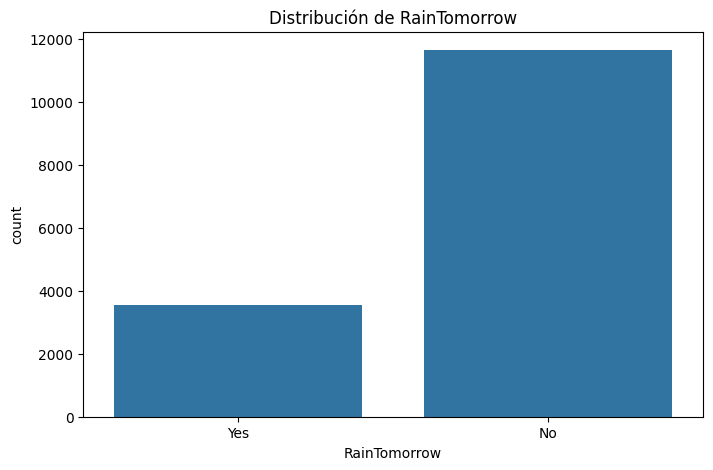

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(x='RainTomorrow', data=df)
plt.title('Distribución de RainTomorrow')
plt.show()

## Se puede observar que el dataset no esta balanceado

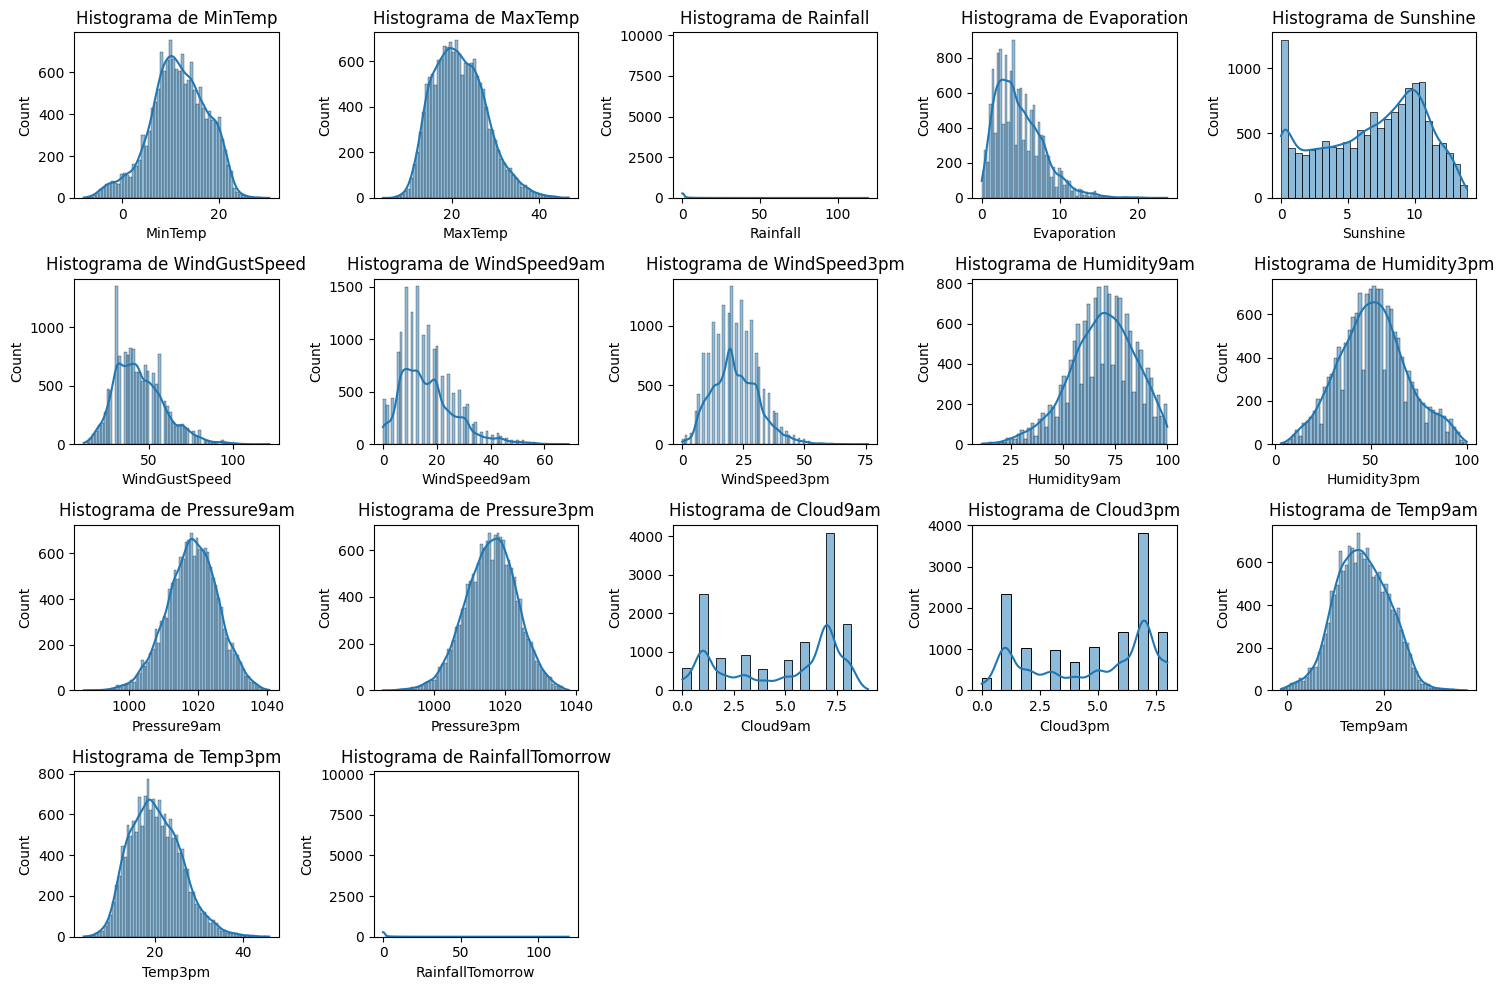

In [10]:
# Seleccionar columnas numéricas
numeric_columns = df.select_dtypes(include=[np.float64]).columns

# Histogramas de las columnas numéricas
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(df[column].dropna(), kde=True)
    plt.title(f'Histograma de {column}')

plt.tight_layout()
plt.show()


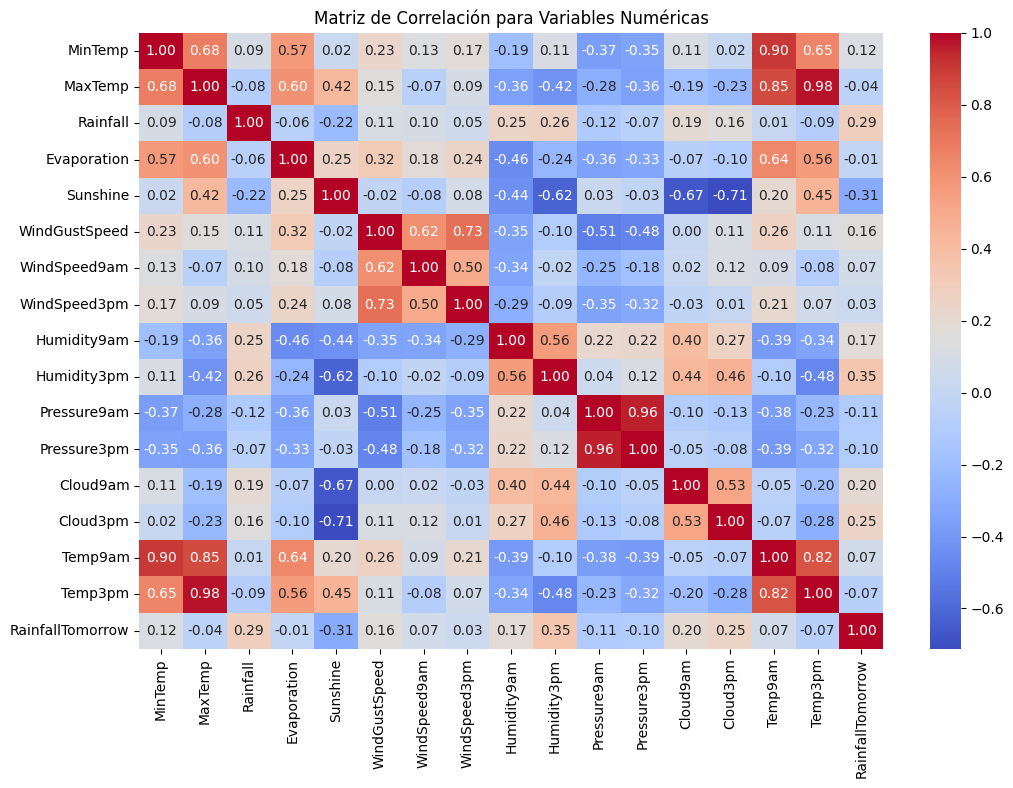

In [11]:
# Matriz de correlación para variables numéricas
correlation_matrix_numeric = df[numeric_columns].corr()

# Plotear la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación para Variables Numéricas')
plt.show()


In [12]:
data = Clean(data_source)
#nos devuelve el dataset limpio
data_clean = data.process()

data_clean.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindSpeed9am,WindSpeed3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
30167,2008-02-01,Sydney,19.5,22.4,15.6,6.2,0.0,3.0,17.0,20.0,...,84.0,1017.6,1017.4,8.0,8.0,20.7,20.9,1,1,6.0
30168,2008-02-02,Sydney,19.5,25.6,6.0,3.4,2.7,4.0,9.0,13.0,...,73.0,1017.9,1016.4,7.0,7.0,22.4,24.8,1,1,6.6
30169,2008-02-03,Sydney,21.6,24.5,6.6,2.4,0.1,2.0,17.0,2.0,...,86.0,1016.7,1015.6,7.0,8.0,23.5,23.0,1,1,18.8
30170,2008-02-04,Sydney,20.2,22.8,18.8,2.2,0.0,1.0,22.0,20.0,...,90.0,1014.2,1011.8,8.0,8.0,21.4,20.9,1,1,77.4
30171,2008-02-05,Sydney,19.7,25.7,77.4,2.2,0.0,1.0,11.0,6.0,...,74.0,1008.3,1004.8,8.0,8.0,22.5,25.5,1,1,1.6


In [13]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15986 entries, 30167 to 70370
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              15986 non-null  object 
 1   Location          15986 non-null  object 
 2   MinTemp           15986 non-null  float64
 3   MaxTemp           15986 non-null  float64
 4   Rainfall          15986 non-null  float64
 5   Evaporation       15986 non-null  float64
 6   Sunshine          15986 non-null  float64
 7   WindGustDir       15751 non-null  float64
 8   WindSpeed9am      15986 non-null  float64
 9   WindSpeed3pm      15986 non-null  float64
 10  Humidity9am       15986 non-null  float64
 11  Humidity3pm       15986 non-null  float64
 12  Pressure9am       15986 non-null  float64
 13  Pressure3pm       15986 non-null  float64
 14  Cloud9am          15986 non-null  float64
 15  Cloud3pm          15986 non-null  float64
 16  Temp9am           15986 non-null  float64

In [14]:
data_clean.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
count,15986.000000,15986.000000,15986.000000,15986.000000,15986.000000,15751.000000,15986.000000,15986.000000,15986.000000,15986.000000,15986.000000,15986.000000,15986.000000,15986.000000,15986.000000,15986.000000,15986.000000,15986.000000,15986.000000
mean,11.787308,21.818829,2.190329,4.566277,6.480533,2.546251,16.643626,21.825034,68.775554,51.484174,1018.401739,1016.217390,4.773114,4.821406,15.701952,20.295746,0.222570,0.229826,2.189228
std,5.852405,5.973914,7.219105,3.072636,3.831093,1.159804,10.277868,9.452757,15.406986,17.489019,7.250865,7.138904,2.688244,2.544679,5.545729,5.779993,0.415985,0.420734,7.218367
min,-8.000000,4.100000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.000000,3.000000,986.700000,985.500000,0.000000,0.000000,-1.300000,3.700000,0.000000,0.000000,0.000000
25%,8.100000,17.300000,0.000000,2.000000,2.800000,1.000000,9.000000,15.000000,59.000000,40.000000,1013.700000,1011.500000,2.000000,2.000000,11.700000,16.000000,0.000000,0.000000,0.000000
50%,11.800000,21.500000,0.000000,4.000000,6.900000,3.000000,15.000000,20.000000,69.000000,52.000000,1018.900000,1016.700000,6.000000,6.000000,15.600000,20.000000,0.000000,0.000000,0.000000
75%,16.300000,25.600000,0.600000,6.400000,9.700000,4.000000,22.000000,28.000000,80.000000,62.000000,1023.100000,1020.800000,7.000000,7.000000,20.000000,24.000000,0.000000,0.000000,0.600000
max,30.500000,46.800000,119.400000,23.800000,13.900000,4.000000,69.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,37.200000,46.100000,1.000000,1.000000,119.400000


In [15]:
print(data_clean.columns)

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow',
       'RainfallTomorrow'],
      dtype='object')


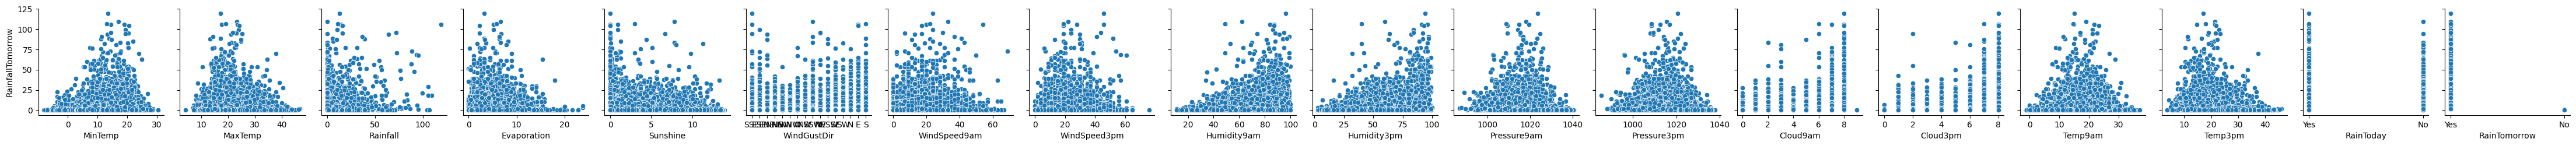

In [16]:
#Observamos la distribución para ver si hay linealidad
columnas = [col for col in data_clean.columns if ((col != 'RainfallTomorrow') & (col != 'Location') & (col != 'Date'))]

sns.pairplot(df, x_vars=columnas, y_vars='RainfallTomorrow')
plt.show()

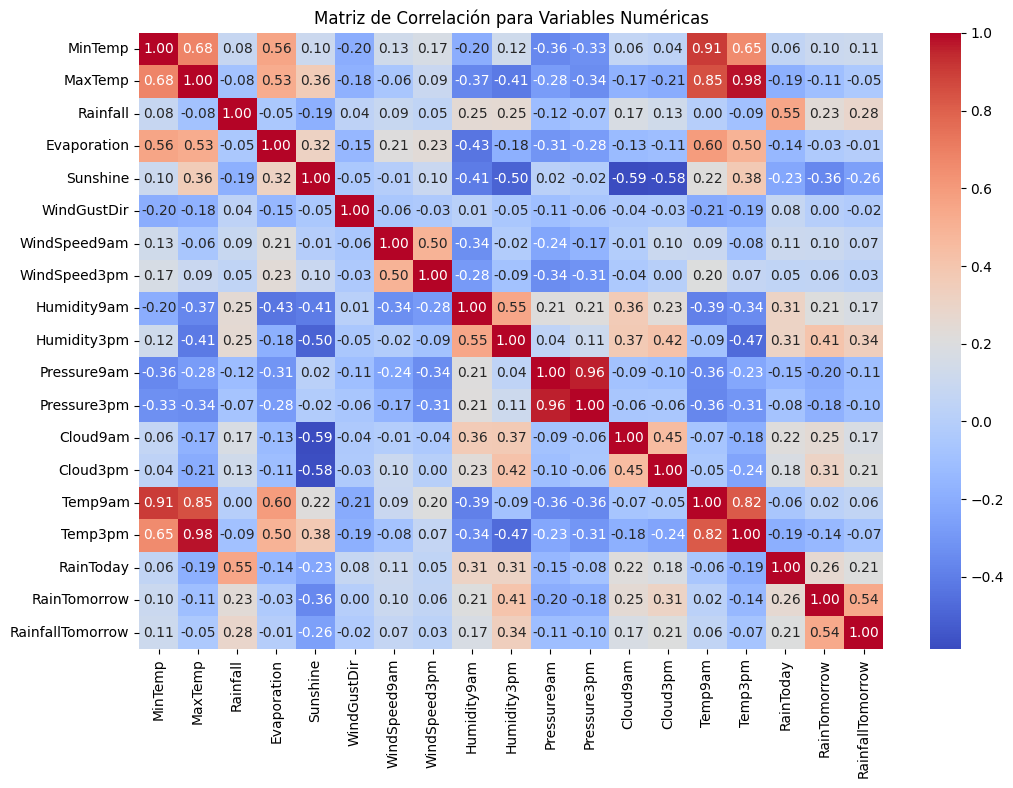

In [17]:
# Seleccionar columnas numéricas
numeric_columns = data_clean.select_dtypes(include=[np.float64, np.int32]).columns

# Matriz de correlación para variables numéricas
correlation_matrix_numeric = data_clean[numeric_columns].corr()

# Plotear la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación para Variables Numéricas')
plt.show()

### En esta parte implementamos en simultaneo las siguientes consignas:

* Implementar la solución del problema de regresión con regresión lineal múltiple.

* Optimizar la selección de hiperparámetros.

* Implementar explicabilidad del modelo. SHAP


In [18]:
regresion_clasic = RegressionLineal(data_clean)
x_test, y_test, y_pred, modelo = regresion_clasic.classic()
metricas = regresion_clasic.metrics(y_test, y_pred)
print(f"Métricas del modelo Regresion lineal clasic:")
print(metricas)

Métricas del modelo Regresion lineal clasic:
{'MSE': 47.50820198147419, 'R2': 0.23107339426699192, 'RMSE': 6.892619384637032, 'MAE': 3.1714750482915472, 'MAPE': inf}


In [19]:
#aplicamos validación cruzada
regresion_clasic.cross_validate(x_test, y_test, modelo, cv=5)

Mean Squared Error (CV): 47.33759154508913
R^2 Score (CV): 0.23383474700779527
Mean Absolute Error (CV): 3.3615017864509436


(47.33759154508913, 0.23383474700779527, 3.3615017864509436)

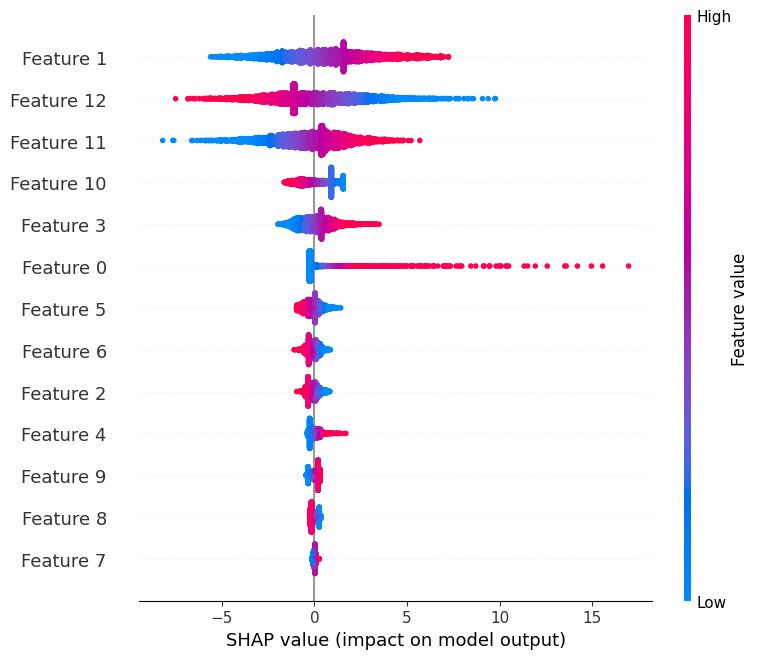

In [20]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [21]:
print('métodos de gradiente descendiente')
regresion_gradient_desecent = RegressionLineal(data_clean)
x_test, y_test, y_pred, modelo = regresion_gradient_desecent.gradient_descent()
metricas = regresion_gradient_desecent.metrics(y_test, y_pred)
print(f"Métricas del Modelo:")
print(metricas)

métodos de gradiente descendiente
Métricas del Modelo:
{'MSE': 56.79599990781452, 'R2': 0.08074914210902084, 'RMSE': 7.53631208933219, 'MAE': 3.2519468021644165, 'MAPE': inf}


In [22]:
#aplicamos validación cruzada
regresion_gradient_desecent.cross_validate(x_test, y_test, modelo, cv=5)

Mean Squared Error (CV): 51.288193133981316
R^2 Score (CV): 0.16989373169564237
Mean Absolute Error (CV): 3.1790962436670593


(51.288193133981316, 0.16989373169564237, 3.1790962436670593)

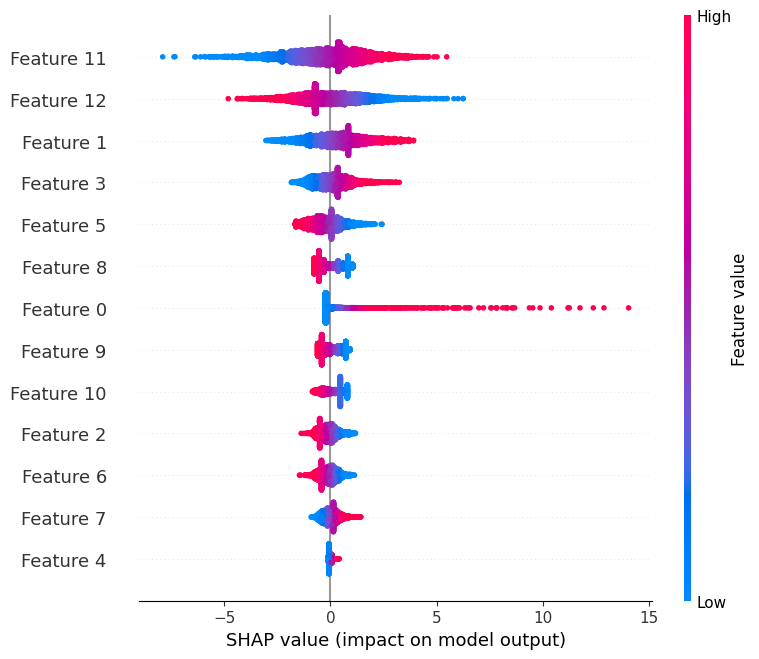

In [23]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [24]:
param_grid = {
    'fit_intercept': [True, False],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'max_iter': [100, 200, 500, 1000]  
}

regresion_gradient_descent = RegressionLineal(data_clean)
x_test, y_test, y_pred, best_model = regresion_gradient_descent.gradient_descent_optimize_hyperparameters(param_grid)
metricas = regresion_gradient_descent.metrics(y_test, y_pred)
print(f"Métricas del mejor modelo:")
print(metricas)
print("Mejores hiperparámetros:", best_model.get_params())

Métricas del mejor modelo:
{'MSE': 48.12347279184615, 'R2': 0.22111515387703995, 'RMSE': 6.937108388359385, 'MAE': 3.078235081879092, 'MAPE': inf}
Mejores hiperparámetros: {'alpha': 0.001, 'average': False, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.01, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'loss': 'squared_error', 'max_iter': 200, 'n_iter_no_change': 5, 'penalty': 'l2', 'power_t': 0.25, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


## Regresión linean de Lasso

In [25]:
# regresion de Lasso
regresion_lasso = RegressionLineal(data_clean)
x_test, y_test, y_pred, lasso_model = regresion_lasso.lasso_regression()
metricas = regresion_lasso.metrics(y_test, y_pred)
print(f"Métricas del modelo Regresion lineal Lasso:")
print(metricas)

Métricas del modelo Regresion lineal Lasso:
{'MSE': 53.66712425849704, 'R2': 0.1313904131410949, 'RMSE': 7.325784890269236, 'MAE': 3.141180334117019, 'MAPE': inf}


In [26]:
#aplicamos validación cruzada
regresion_lasso.cross_validate(x_test, y_test, modelo, cv=5)

Mean Squared Error (CV): 49.08077228562466
R^2 Score (CV): 0.2056211334822442
Mean Absolute Error (CV): 3.4188663941494672


(49.08077228562466, 0.2056211334822442, 3.4188663941494672)

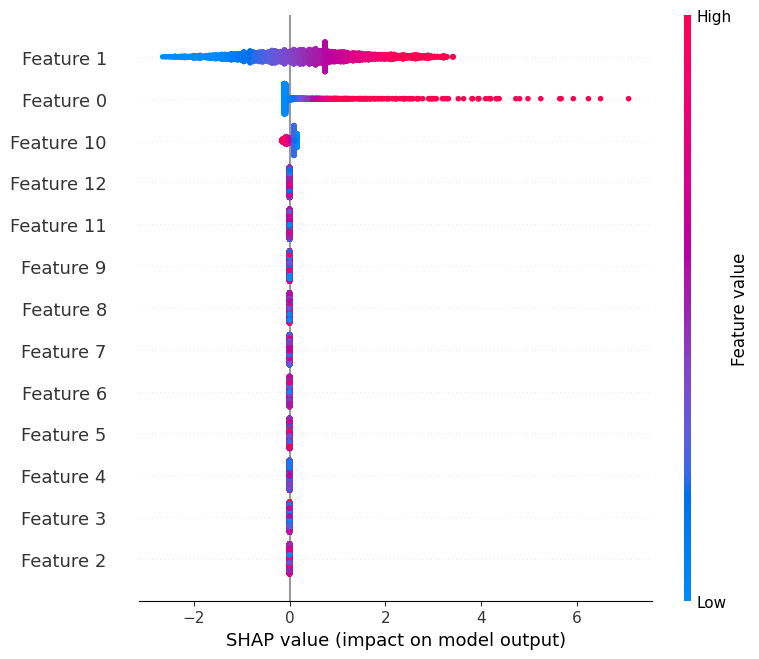

In [27]:
try:
    shap_analyzer = SHAPAnalyzer(lasso_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [28]:
# Crear una instancia de la clase RegressionLineal
regresion_lineal = RegressionLineal(data_clean)

# Definir el rango de valores para el hiperparámetro alpha
param_grid_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# Llamar al método optimize_hyperparameters para Lasso
x_test, y_test, y_pred_lasso, best_lasso_model = regresion_lineal.optimize_hyperparameters('Lasso', param_grid_lasso)

# Calcular métricas
metricas_lasso = regresion_lineal.metrics(y_test, y_pred_lasso)

# Imprimir métricas y mejores hiperparámetros para Lasso
print(f"Métricas del mejor modelo Lasso:")
print(metricas_lasso)
print("Mejores hiperparámetros para Lasso:", best_lasso_model.get_params())


The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Métricas del mejor modelo Lasso:
{'MSE': 47.5149973892743, 'R2': 0.23096340968251217, 'RMSE': 6.893112315150124, 'MAE': 3.170054496345279, 'MAPE': inf}
Mejores hiperparámetros para Lasso: {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


## Regresión lineal de Ridge

In [29]:
# regresion de Ridge

regresion_ridge = RegressionLineal(data_clean)
x_test, y_test, y_pred, ridge_model = regresion_ridge.ridge_regression()
metricas = regresion_lasso.metrics(y_test, y_pred)
print(f"Métricas del modelo Regresion lineal Ridge:")
print(metricas)


Métricas del modelo Regresion lineal Ridge:
{'MSE': 47.50864951390231, 'R2': 0.23106615089476212, 'RMSE': 6.892651849172589, 'MAE': 3.1713398974779725, 'MAPE': inf}


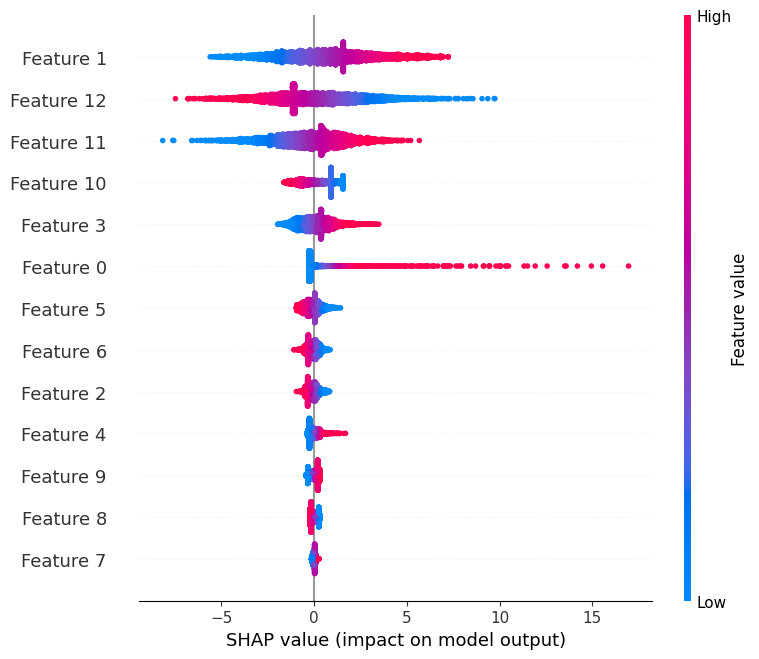

In [30]:
try:
    shap_analyzer = SHAPAnalyzer(ridge_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [31]:
# Crear una instancia de la clase RegressionLineal
regresion_lineal = RegressionLineal(data_clean)

# Definir el rango de valores para el hiperparámetro alpha
param_grid_Ridge = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# Llamar al método optimize_hyperparameters para Lasso
x_test, y_test, y_pred_lasso, best_lasso_model = regresion_lineal.optimize_hyperparameters('Ridge', param_grid_Ridge)

# Calcular métricas
metricas_lasso = regresion_lineal.metrics(y_test, y_pred_lasso)

# Imprimir métricas y mejores hiperparámetros para Lasso
print(f"Métricas del mejor modelo Ridge:")
print(metricas_lasso)
print("Mejores hiperparámetros para Ridge:", best_lasso_model.get_params())

The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.


Métricas del mejor modelo Ridge:
{'MSE': 47.50923969019444, 'R2': 0.23105659881250773, 'RMSE': 6.892694661030216, 'MAE': 3.171258155559849, 'MAPE': inf}
Mejores hiperparámetros para Ridge: {'alpha': 100.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


## Regresión lineal de Elasticnet

In [32]:
# regresion de Elasticnet

regresion_elasticnet = RegressionLineal(data_clean)
x_test, y_test, y_pred, elasticnet_model = regresion_elasticnet.elasticnet_regression()
metricas = regresion_elasticnet.metrics(y_test, y_pred)
print(f"Métricas del modelo Regresion lineal Elasticnet:")
print(metricas)

Métricas del modelo Regresion lineal Elasticnet:
{'MSE': 52.438756600365416, 'R2': 0.15127170804523937, 'RMSE': 7.241460943785129, 'MAE': 3.069001039742992, 'MAPE': inf}


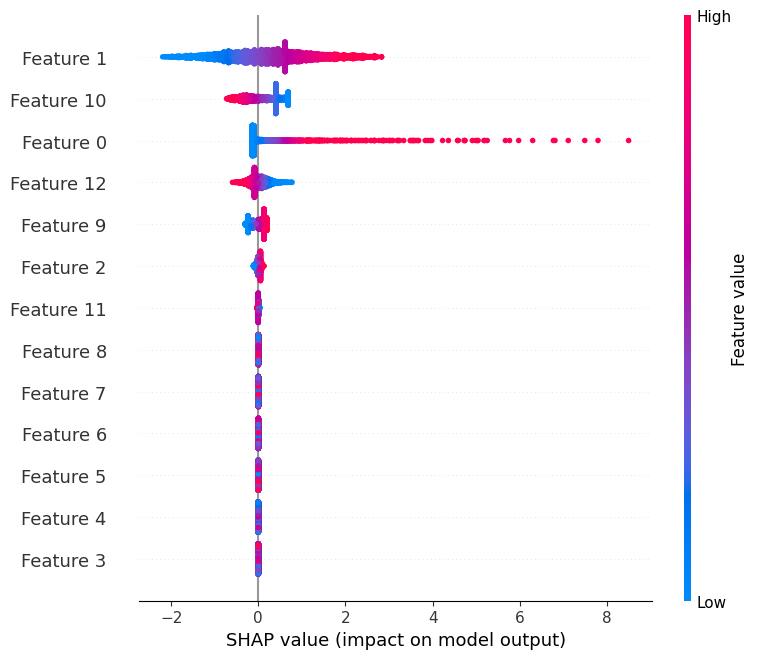

In [33]:
try:
    shap_analyzer = SHAPAnalyzer(elasticnet_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [34]:
regresion_lineal = RegressionLineal(data_clean)

# Definir el rango de valores para el hiperparámetro alpha
param_grid_Elasticnet = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Puedes ajustar estos valores según sea necesario
}
# Llamar al método optimize_hyperparameters para Lasso
x_test, y_test, y_pred_elasticnet, best_lasso_model = regresion_lineal.optimize_hyperparameters('ElasticNet', param_grid_Elasticnet)

# Calcular métricas
metricas_elasticnet = regresion_lineal.metrics(y_test, y_pred_elasticnet)

# Imprimir métricas y mejores hiperparámetros para Lasso
print(f"Métricas del mejor modelo Elasticnet:")
print(metricas_elasticnet)
print("Mejores hiperparámetros para Elasticnet:", best_lasso_model.get_params())

Métricas del mejor modelo Elasticnet:
{'MSE': 47.542051939697274, 'R2': 0.2305255281639802, 'RMSE': 6.895074469481623, 'MAE': 3.166031713658998, 'MAPE': inf}
Mejores hiperparámetros para Elasticnet: {'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.3, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


## Regresión Logística

Accuracy: 0.99
Precision: 0.99
Recall: 0.96
F1 Score: 0.97
ROC-AUC: 0.98
Matiz de confusión:
          pred: No  Pred: Si
Real: No      2478         7
Real: si        32       681


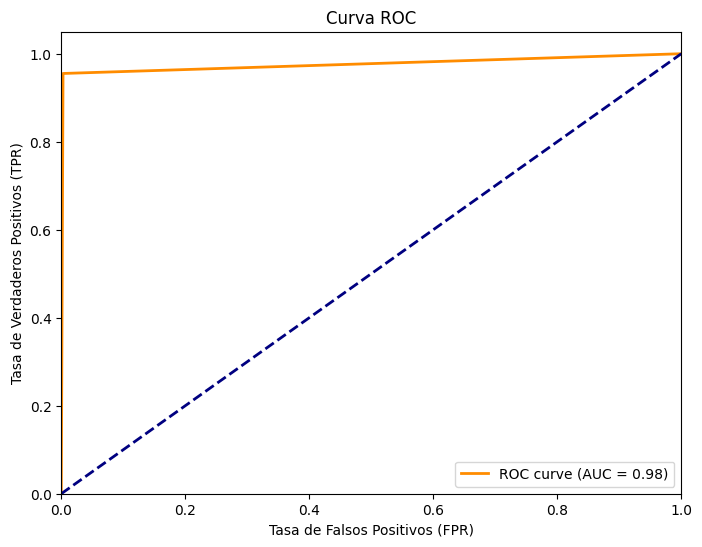

In [35]:
#regresion logistica
regression_logistic = RegressionLineal(data_clean)
x_test, y_test, y_pred, modelo = regression_logistic.logistic()
regression_logistic.logic_metrics(y_test, y_pred)

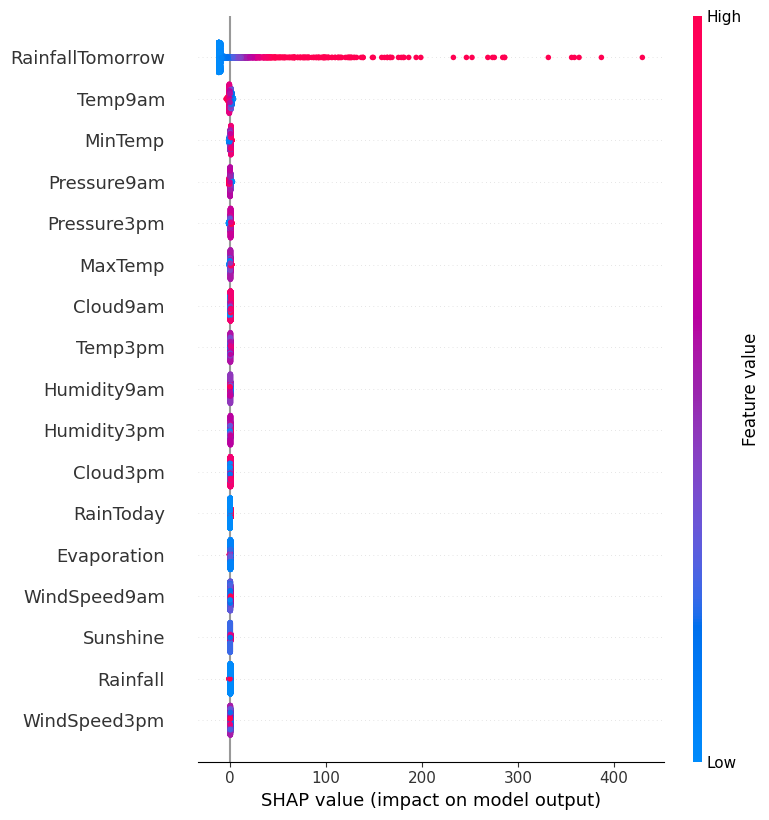

In [36]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [37]:
regresion_lineal = RegressionLineal(data_clean)
#buscando los hipperparametros
param_grid_logistic = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
x_test_logistic, y_test_logistic, y_pred_logistic, best_logistic_model = regresion_lineal.optimize_hyperparameters_logistic(param_grid_logistic)

# Calcular métricas
metricas_logistic = regresion_lineal.metrics(y_test_logistic, y_pred_logistic)

# Imprimir métricas y mejores hiperparámetros para la regresión logística
print(f"Métricas del mejor modelo de regresión logística:")
print(metricas_logistic)
print("Mejores hiperparámetros para la regresión logística:", best_logistic_model.get_params())


Métricas del mejor modelo de regresión logística:
{'MSE': 0.012195121951219513, 'R2': 0.9334060202726081, 'RMSE': 0.11043152607484655, 'MAE': 0.012195121951219513, 'MAPE': inf}
Mejores hiperparámetros para la regresión logística: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


### Observamos que tanto el modelo como la validación cruzada tienden a sobreajustar las predicciones hacia la clase negativa. Esto se debe a que la clase negativa es la más predominante. Para abordar este desbalance, procedemos a equilibrar las clases.

Accuracy: 0.97
Precision: 0.93
Recall: 0.97
F1 Score: 0.95
ROC-AUC: 0.97
Matiz de confusión:
          pred: No  Pred: Si
Real: No      2368        58
Real: si        27       745


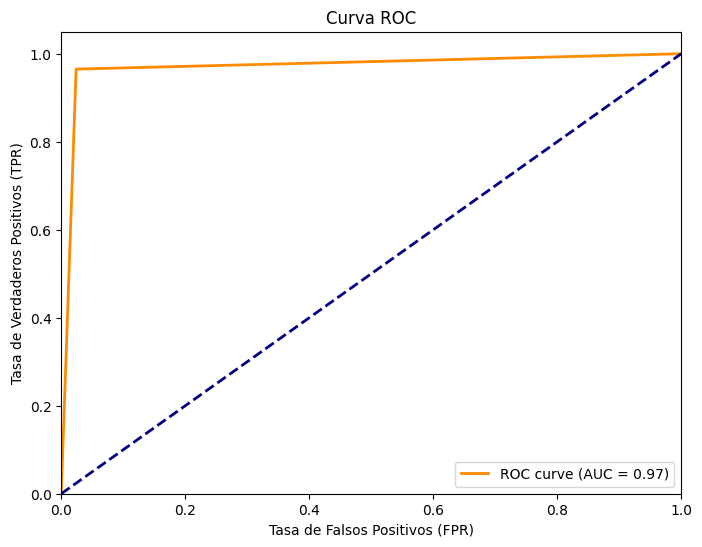

In [38]:
#regresion logistica balanceada
regression_logistic = RegressionLineal(data_clean)
x_test, y_test, y_pred, modelo = regression_logistic.logistic_balanced()
regression_logistic.logic_metrics(y_test, y_pred)

### Optamos por mantener el modelo balanceado, ya que aunque observamos una disminución en las métricas de predicción negativa, consideramos prioritario mejorar las métricas de predicción positiva. En este contexto, valoramos una mayor precisión en la anticipación de días lluviosos.

## Implementar un modelo base para clasificación y uno para regresión

In [39]:
#modelo base
regresion_model = RegresionModelBase(data_clean)
x_test, y_test, y_pred, modelo = regresion_model.regresion()


# También puedes acceder a los atributos del mejor modelo obtenido
print("Mejores hiperparámetros encontrados mediante Grid Search:")
print(modelo.get_params())

Error Cuadrático Medio en el conjunto de prueba: 34.93810444635379
Error Absoluto Medio en el conjunto de prueba: 2.2135707503665714
Raíz del Error Cuadrático Medio en el conjunto de prueba: 5.910846339260884
Coeficiente de Determinación (R^2) en el conjunto de prueba: 0.36523519417701134
Mejores hiperparámetros encontrados mediante Grid Search:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}


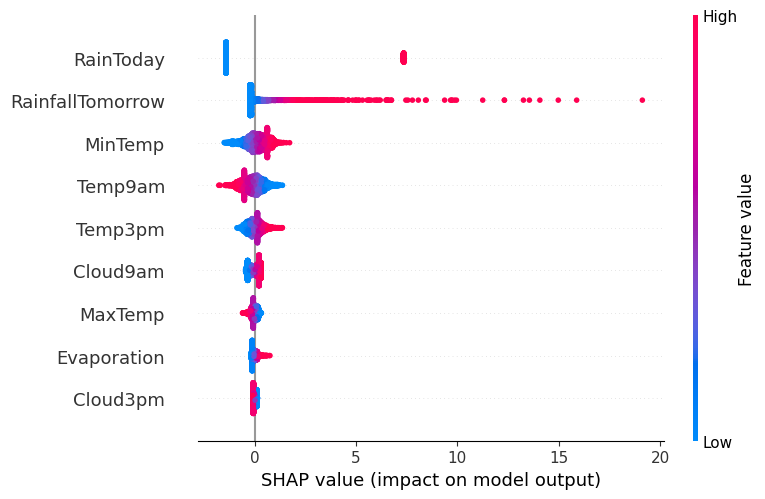

In [40]:
try:
    shap_analyzer = SHAPAnalyzer(modelo, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

In [41]:
#clasificador Base
clasification_model = ClasificationModelBase(data_clean)
# Entrenar el modelo y obtener los resultados
x_test, y_test, predictions, best_model = clasification_model.clasificacion()
print("Mejores hiperparámetros encontrados mediante Grid Search:")
print(best_model.get_params())

Precisión en el conjunto de prueba: 0.68
Recall en el conjunto de prueba: 0.33
F1-score en el conjunto de prueba: 0.45
Exactitud en el conjunto de prueba: 0.80
Mejores hiperparámetros encontrados mediante Grid Search:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


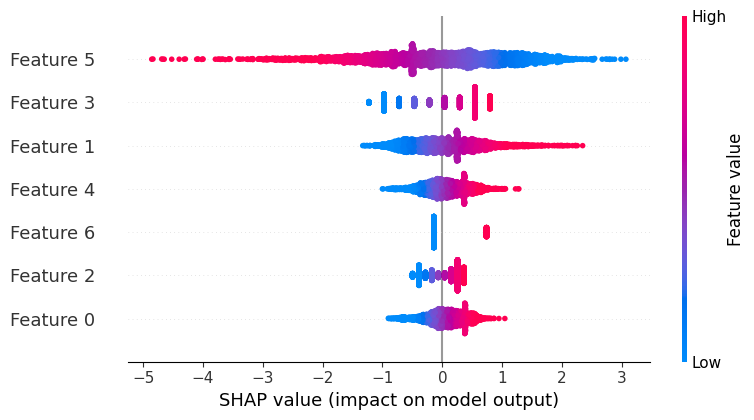

In [42]:
try:
    shap_analyzer = SHAPAnalyzer(best_model, x_test)
    shap_analyzer.summary_plot()
except Exception as e:
    print(f"Error en la función apply_shap: {str(e)}")

## Implementar las soluciones con una red neuronal

In [43]:
print('=============================clasificacion con redes neuronales================================================')
classification_nn_model = ClassificationNeuralNetwork(data_clean)
trained_model = classification_nn_model.classification()


[I 2023-12-09 22:33:56,333] A new study created in memory with name: no-name-85aab9a8-d820-433d-a75d-6c3a6555cceb
[W 2023-12-09 22:33:56,336] Trial 0 failed with parameters: {} because of the following error: KeyError("['WindGustDir_numerico'] not in index").
Traceback (most recent call last):
  File "c:\Users\mirian\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "c:\Users\mirian\TP_AA1\code\neural_network\classification_neural.py", line 26, in objective
    X = self.data[self.features]
  File "c:\Users\mirian\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 3899, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
  File "c:\Users\mirian\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexes\base.py", line 6114, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File

=============================clasificacion con redes neuronales================================================


KeyError: "['WindGustDir_numerico'] not in index"

In [ ]:
regression_nn_model = RegressionNeuralNetwork(data_clean)
regression_nn_model.regression_with_shap()
# regression_nn_model.regression_with_shap()

[I 2023-12-09 17:00:56,741] A new study created in memory with name: no-name-c421113d-6f60-4dd6-ace3-d042b576c815
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:01:03,283] Trial 0 finished with value: 5.39570681806045 and parameters: {'learning_rate': 0.002327102793397972}. Best is trial 0 with value: 5.39570681806045.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 2ms/step


[I 2023-12-09 17:01:10,878] Trial 1 finished with value: 26.16630735240928 and parameters: {'learning_rate': 0.0007512298878812213}. Best is trial 0 with value: 5.39570681806045.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 2ms/step


[I 2023-12-09 17:01:18,440] Trial 2 finished with value: 18.51993401887451 and parameters: {'learning_rate': 0.0015216763531462967}. Best is trial 0 with value: 5.39570681806045.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:01:24,866] Trial 3 finished with value: 1.0277563376097343 and parameters: {'learning_rate': 0.0037940609314246814}. Best is trial 3 with value: 1.0277563376097343.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:01:31,034] Trial 4 finished with value: 21.13480439951979 and parameters: {'learning_rate': 0.001617322271458608}. Best is trial 3 with value: 1.0277563376097343.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:01:37,039] Trial 5 finished with value: 35.21834257395136 and parameters: {'learning_rate': 0.0008455568774654907}. Best is trial 3 with value: 1.0277563376097343.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:01:42,985] Trial 6 finished with value: 57.010047437132435 and parameters: {'learning_rate': 1.6956285043508902e-05}. Best is trial 3 with value: 1.0277563376097343.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 983us/step


[I 2023-12-09 17:01:48,860] Trial 7 finished with value: 9.953233202798401 and parameters: {'learning_rate': 0.001972073458923954}. Best is trial 3 with value: 1.0277563376097343.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:01:55,095] Trial 8 finished with value: 48.6434745411659 and parameters: {'learning_rate': 0.00012779897544130142}. Best is trial 3 with value: 1.0277563376097343.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:02:01,468] Trial 9 finished with value: 48.47583526751854 and parameters: {'learning_rate': 0.00018334587648971462}. Best is trial 3 with value: 1.0277563376097343.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:02:07,682] Trial 10 finished with value: 6.547280145346067e-12 and parameters: {'learning_rate': 0.027136222693885884}. Best is trial 10 with value: 6.547280145346067e-12.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 2ms/step


[I 2023-12-09 17:02:13,807] Trial 11 finished with value: 7.010047386515101e-12 and parameters: {'learning_rate': 0.038849352895860424}. Best is trial 10 with value: 6.547280145346067e-12.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:02:20,231] Trial 12 finished with value: 5.129795800448359e-13 and parameters: {'learning_rate': 0.05932278107313374}. Best is trial 12 with value: 5.129795800448359e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:02:26,236] Trial 13 finished with value: 2.2877128806851747e-13 and parameters: {'learning_rate': 0.09240049322876462}. Best is trial 13 with value: 2.2877128806851747e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:02:32,460] Trial 14 finished with value: 3.419387888496119e-13 and parameters: {'learning_rate': 0.07447449900064777}. Best is trial 13 with value: 2.2877128806851747e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:02:38,499] Trial 15 finished with value: 4.1552813023753404e-13 and parameters: {'learning_rate': 0.08533026337978826}. Best is trial 13 with value: 2.2877128806851747e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:02:44,574] Trial 16 finished with value: 1.574736381212232e-07 and parameters: {'learning_rate': 0.013206225589060873}. Best is trial 13 with value: 2.2877128806851747e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:02:50,475] Trial 17 finished with value: 3.8848740683337383e-13 and parameters: {'learning_rate': 0.09597160564082645}. Best is trial 13 with value: 2.2877128806851747e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:02:56,683] Trial 18 finished with value: 2.3120405111093562e-07 and parameters: {'learning_rate': 0.014692838845430226}. Best is trial 13 with value: 2.2877128806851747e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:03:02,722] Trial 19 finished with value: 0.0002442693158187363 and parameters: {'learning_rate': 0.009080862217017358}. Best is trial 13 with value: 2.2877128806851747e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:03:08,973] Trial 20 finished with value: 1.3349205507126196e-12 and parameters: {'learning_rate': 0.03045534321729385}. Best is trial 13 with value: 2.2877128806851747e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 2ms/step


[I 2023-12-09 17:03:16,405] Trial 21 finished with value: 3.186987110890309e-13 and parameters: {'learning_rate': 0.09567499372802231}. Best is trial 13 with value: 2.2877128806851747e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:03:23,423] Trial 22 finished with value: 8.574270298776407e-13 and parameters: {'learning_rate': 0.09841181032868351}. Best is trial 13 with value: 2.2877128806851747e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:03:29,392] Trial 23 finished with value: 1.245489969551638e-12 and parameters: {'learning_rate': 0.035301207584851856}. Best is trial 13 with value: 2.2877128806851747e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:03:35,424] Trial 24 finished with value: 2.6234597271062915e-12 and parameters: {'learning_rate': 0.044279037391388935}. Best is trial 13 with value: 2.2877128806851747e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:03:41,929] Trial 25 finished with value: 5.4196472539916624e-08 and parameters: {'learning_rate': 0.016289834236860104}. Best is trial 13 with value: 2.2877128806851747e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:03:47,939] Trial 26 finished with value: 4.0979782069741927e-13 and parameters: {'learning_rate': 0.05664121650036632}. Best is trial 13 with value: 2.2877128806851747e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:03:54,081] Trial 27 finished with value: 0.009850515225812909 and parameters: {'learning_rate': 0.0067308093573910715}. Best is trial 13 with value: 2.2877128806851747e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:04:00,446] Trial 28 finished with value: 2.8169839879218566e-11 and parameters: {'learning_rate': 0.021819256048575687}. Best is trial 13 with value: 2.2877128806851747e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:04:07,827] Trial 29 finished with value: 1.168694627756713e-12 and parameters: {'learning_rate': 0.050445012634688}. Best is trial 13 with value: 2.2877128806851747e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:04:15,494] Trial 30 finished with value: 0.16729623973944036 and parameters: {'learning_rate': 0.005108706427995139}. Best is trial 13 with value: 2.2877128806851747e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:04:21,784] Trial 31 finished with value: 2.75970299578548e-13 and parameters: {'learning_rate': 0.096997566465429}. Best is trial 13 with value: 2.2877128806851747e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:04:28,035] Trial 32 finished with value: 1.6931749263155245e-13 and parameters: {'learning_rate': 0.09495599454380449}. Best is trial 32 with value: 1.6931749263155245e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:04:34,173] Trial 33 finished with value: 4.132766928044321e-13 and parameters: {'learning_rate': 0.026556115277625886}. Best is trial 32 with value: 1.6931749263155245e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:04:40,323] Trial 34 finished with value: 4.8557659229372225e-12 and parameters: {'learning_rate': 0.05289907222407136}. Best is trial 32 with value: 1.6931749263155245e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:04:46,284] Trial 35 finished with value: 5.787133407846221e-13 and parameters: {'learning_rate': 0.0961505383496876}. Best is trial 32 with value: 1.6931749263155245e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 2ms/step


[I 2023-12-09 17:04:52,491] Trial 36 finished with value: 2.369415017494663e-07 and parameters: {'learning_rate': 0.01774924698720339}. Best is trial 32 with value: 1.6931749263155245e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:04:58,412] Trial 37 finished with value: 1.5252462439652677e-13 and parameters: {'learning_rate': 0.03770280111901634}. Best is trial 37 with value: 1.5252462439652677e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:05:04,573] Trial 38 finished with value: 1.379772214832674 and parameters: {'learning_rate': 0.003491253327710706}. Best is trial 37 with value: 1.5252462439652677e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:05:10,939] Trial 39 finished with value: 1.2911493514161893e-05 and parameters: {'learning_rate': 0.009944285449628361}. Best is trial 37 with value: 1.5252462439652677e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:05:16,866] Trial 40 finished with value: 1.555447977863204e-13 and parameters: {'learning_rate': 0.03927344040576787}. Best is trial 37 with value: 1.5252462439652677e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:05:23,046] Trial 41 finished with value: 2.50717327122779e-12 and parameters: {'learning_rate': 0.03611965101204282}. Best is trial 37 with value: 1.5252462439652677e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:05:29,007] Trial 42 finished with value: 1.1686007363561834e-12 and parameters: {'learning_rate': 0.057377132255050256}. Best is trial 37 with value: 1.5252462439652677e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:05:34,990] Trial 43 finished with value: 1.4976900961113816e-12 and parameters: {'learning_rate': 0.022646229494403043}. Best is trial 37 with value: 1.5252462439652677e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:05:40,950] Trial 44 finished with value: 2.859355025662083e-12 and parameters: {'learning_rate': 0.032875671502722977}. Best is trial 37 with value: 1.5252462439652677e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:05:46,867] Trial 45 finished with value: 1.2301054720489642e-12 and parameters: {'learning_rate': 0.06362817881934689}. Best is trial 37 with value: 1.5252462439652677e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:05:52,667] Trial 46 finished with value: 2.979362906328302e-12 and parameters: {'learning_rate': 0.04684963158102708}. Best is trial 37 with value: 1.5252462439652677e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:05:58,616] Trial 47 finished with value: 1.5561032616026098e-13 and parameters: {'learning_rate': 0.06376754309162273}. Best is trial 37 with value: 1.5252462439652677e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:06:04,404] Trial 48 finished with value: 1.0161240358616537e-12 and parameters: {'learning_rate': 0.02549166217854269}. Best is trial 37 with value: 1.5252462439652677e-13.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


91/91 [==============================] - 0s 1ms/step


[I 2023-12-09 17:06:10,326] Trial 49 finished with value: 5.258355506567986e-06 and parameters: {'learning_rate': 0.010673194571920152}. Best is trial 37 with value: 1.5252462439652677e-13.


Epoch 1/10
364/364 [==============================] - 1s 1ms/step - loss: 12.7404
Epoch 2/10
364/364 [==============================] - 0s 1ms/step - loss: 0.1799
Epoch 3/10
364/364 [==============================] - 0s 1ms/step - loss: 4.9158e-04
Epoch 4/10
364/364 [==============================] - 0s 1ms/step - loss: 2.7776e-05
Epoch 5/10
364/364 [==============================] - 0s 1ms/step - loss: 1.7287e-06
Epoch 6/10
364/364 [==============================] - 0s 1ms/step - loss: 5.3033e-08
Epoch 7/10
364/364 [==============================] - 0s 1ms/step - loss: 6.9539e-10
Epoch 8/10
364/364 [==============================] - 0s 1ms/step - loss: 5.2096e-12
Epoch 9/10
364/364 [==============================] - 0s 1ms/step - loss: 2.1979e-12
Epoch 10/10
364/364 [==============================] - 0s 1ms/step - loss: 2.1888e-12


AttributeError: module 'shap_analyzer' has no attribute 'Explainer'